In [1]:
from tensorflow.keras.datasets import fashion_mnist
(X_train, Y_train), (X_test, Y_test) = fashion_mnist.load_data()

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import tensorflow as tf
import numpy as np

In [4]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten,Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, RMSprop

In [5]:
class CustomCallbacks(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
      if(logs.get('accuracy')>0.95):
        print("\n 95% acc reached")
        self.model.stop_training = True

In [6]:
img_width  = 28
img_height = 28
channels   = 1

num_classes = 10

batch_size = 250
num_epochs = 80
# iterations = 5
nb_augmentation = 2   

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Defines the options for augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    horizontal_flip=True,
    fill_mode='nearest'
)

def image_augmentation(image, nb_of_augmentation):
    '''
    Generates new images bei augmentation
    image : raw image
    nb_augmentation: number of augmentations
    images: array with new images
    '''
    images = []
    image = image.reshape(1, img_height, img_width, channels)
    i = 0
    for x_batch in datagen.flow(image, batch_size=1):
        images.append(x_batch)
        i += 1
        if i >= nb_of_augmentation:
            # interrupt augmentation
            break
    return images

In [8]:
import tensorflow as tf

def preprocess_data(images, targets, use_augmentation=False, nb_of_augmentation=1):
    """
    images: raw image
    targets: target label
    use_augmentation: True if augmentation should be used
    nb_of_augmentation: If use_augmentation=True, number of augmentations
    """
    X = []
    y = []
    for x_, y_ in zip(images, targets):
        
        # scaling pixels between 0.0-1.0
        x_ = x_ / 255.
        
        # data Augmentation
        if use_augmentation:
            argu_img = image_augmentation(x_, nb_of_augmentation)
            for a in argu_img:
                X.append(a.reshape(img_height, img_width, channels))
                y.append(y_)

        X.append(x_)
        y.append(y_)
    print('*Preprocessing completed: %i samples\n' % len(X))
    return np.array(X), tf.keras.utils.to_categorical(y)

In [9]:
X_train = X_train.reshape(-1, 28, 28, 1)

In [10]:
X_train_shaped, y_train_shaped = preprocess_data(
    X_train, Y_train, 
    use_augmentation=True, 
    nb_of_augmentation=nb_augmentation
)


*Preprocessing completed: 180000 samples



In [11]:
X_test_shaped, y_test_shaped   = preprocess_data(X_test,  Y_test)

*Preprocessing completed: 10000 samples



In [12]:
def create_model():
    """
    Creates a simple sequential model
    """
    
    cnn = tf.keras.Sequential()
    
    cnn.add(tf.keras.layers.InputLayer(input_shape=(img_height,img_width,channels)))
    
    # Normalization
    cnn.add(tf.keras.layers.BatchNormalization())
    
    # Conv + Maxpooling
    cnn.add(tf.keras.layers.Convolution2D(64, (4, 4), padding='same', activation='relu'))
    cnn.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

    # Dropout
    cnn.add(tf.keras.layers.Dropout(0.1))
    
    # Conv + Maxpooling
    cnn.add(tf.keras.layers.Convolution2D(64, (4, 4), activation='relu'))
    cnn.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

    # Dropout
    cnn.add(tf.keras.layers.Dropout(0.3))

    # Converting 3D feature to 1D feature Vektor
    cnn.add(tf.keras.layers.Flatten())

    # Fully Connected Layer
    cnn.add(tf.keras.layers.Dense(256, activation='relu'))

    # Dropout
    cnn.add(tf.keras.layers.Dropout(0.5))
    
    # Fully Connected Layer
    cnn.add(tf.keras.layers.Dense(64, activation='relu'))
    
    # Normalization
    cnn.add(tf.keras.layers.BatchNormalization())

    cnn.add(tf.keras.layers.Dense(num_classes, activation='softmax'))
    cnn.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy']) #RMSprop()

    return cnn

create_model().summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 28, 28, 1)         4         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 64)        1088      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        65600     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 5, 64)          0

In [13]:
from sklearn.model_selection import train_test_split
X_train_, X_val_, y_train_, y_val_ = train_test_split(X_train_shaped, y_train_shaped,test_size=0.2, random_state=42)

In [14]:
cnn = create_model()
history = cnn.fit(
                    X_train_,
                    y_train_,
                    epochs=num_epochs,
                    batch_size=batch_size,
                    validation_data=(X_val_, y_val_),
                    callbacks=[CustomCallbacks()]
                )

Epoch 1/80
576/576 [==============================] - 130s 226ms/step - loss: 0.4994 - accuracy: 0.8203 - val_loss: 0.3910 - val_accuracy: 0.8535
Epoch 2/80
576/576 [==============================] - 130s 226ms/step - loss: 0.3324 - accuracy: 0.8777 - val_loss: 0.2720 - val_accuracy: 0.8990
Epoch 3/80
576/576 [==============================] - 127s 220ms/step - loss: 0.2957 - accuracy: 0.8923 - val_loss: 0.2495 - val_accuracy: 0.9081
Epoch 4/80
576/576 [==============================] - 124s 215ms/step - loss: 0.2746 - accuracy: 0.8997 - val_loss: 0.2367 - val_accuracy: 0.9137
Epoch 5/80
576/576 [==============================] - 123s 214ms/step - loss: 0.2585 - accuracy: 0.9055 - val_loss: 0.2281 - val_accuracy: 0.9156
Epoch 6/80
576/576 [==============================] - 123s 214ms/step - loss: 0.2473 - accuracy: 0.9094 - val_loss: 0.2245 - val_accuracy: 0.9192
Epoch 7/80
576/576 [==============================] - 122s 213ms/step - loss: 0.2373 - accuracy: 0.9135 - val_loss: 0.2296 -

Epoch 57/80
576/576 [==============================] - 129s 225ms/step - loss: 0.1506 - accuracy: 0.9446 - val_loss: 0.1592 - val_accuracy: 0.9429
Epoch 58/80
576/576 [==============================] - 126s 219ms/step - loss: 0.1517 - accuracy: 0.9446 - val_loss: 0.1683 - val_accuracy: 0.9410
Epoch 59/80
576/576 [==============================] - 132s 228ms/step - loss: 0.1511 - accuracy: 0.9455 - val_loss: 0.1640 - val_accuracy: 0.9412
Epoch 60/80
576/576 [==============================] - 128s 223ms/step - loss: 0.1496 - accuracy: 0.9457 - val_loss: 0.1602 - val_accuracy: 0.9421
Epoch 61/80
576/576 [==============================] - 127s 220ms/step - loss: 0.1474 - accuracy: 0.9465 - val_loss: 0.1548 - val_accuracy: 0.9449
Epoch 62/80
576/576 [==============================] - 138s 240ms/step - loss: 0.1475 - accuracy: 0.9461 - val_loss: 0.1509 - val_accuracy: 0.9453
Epoch 63/80
576/576 [==============================] - 135s 235ms/step - loss: 0.1493 - accuracy: 0.9458 - val_loss: 0

In [40]:
 cnn.save_weights("fashion-mnist.hdf5") #with adam

In [15]:
 cnn.save_weights("fashion-mnist-1.hdf5") #with rmsprop

In [16]:
def plot_acc_loss(title, model, key_acc, key_loss):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    
    # Accuracy
    ax1.set_title('Model accuracy (%s)' % title)
    names = []
    ax1.plot(model[key_acc])
    ax1.set_xlabel('epoch')
    names.append('Model')
    ax1.set_ylabel('accuracy')
    ax1.legend(names, loc='upper left')
    
    # Loss
    ax2.set_title('Model loss')
    ax2.plot(model[key_loss])
    ax2.set_xlabel('epoch')
    ax2.set_ylabel('loss')
    ax2.legend(names, loc='upper right')
    fig.set_size_inches(20, 5)
    plt.show()

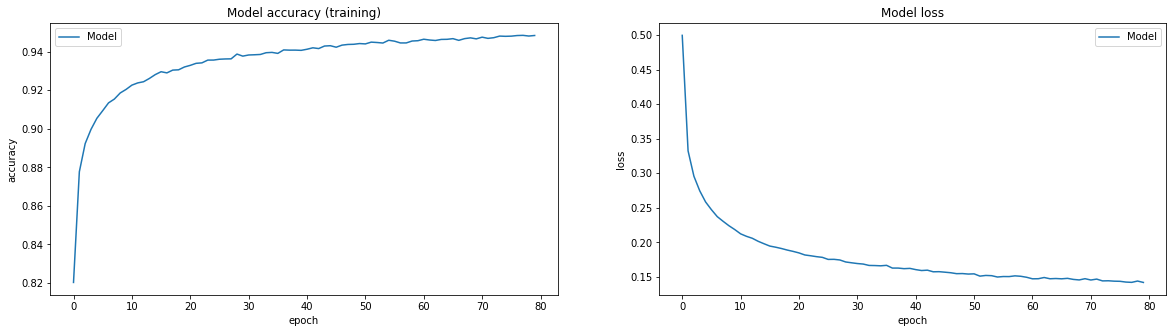

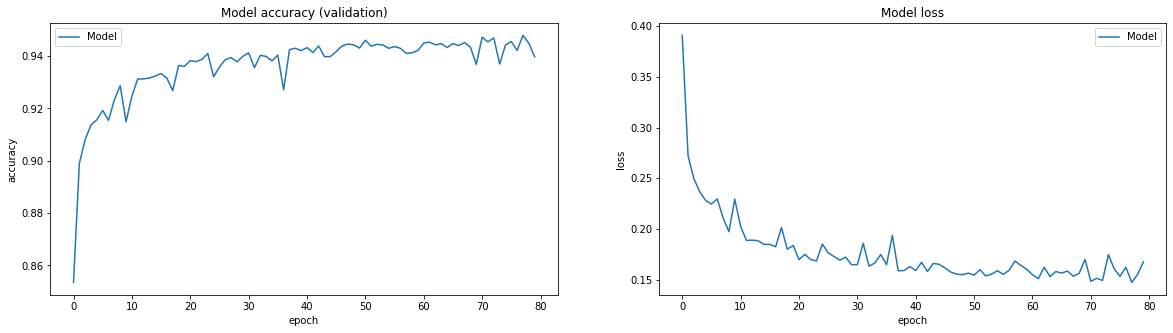

In [17]:
plot_acc_loss('training', history.history, 'accuracy', 'loss')
plot_acc_loss('validation', history.history, 'val_accuracy', 'val_loss')